In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'},
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import pandas as pd
import seaborn as sns 
import codecs, json

# generates same random numbers each time
# np.random.seed(1234)
# tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.0.0


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
x_1 = np.linspace(-1,1,256)  # 256 points between -1 and 1 [256x1]
x_2 = np.linspace(1,-1,256)  # 256 points between 1 and -1 [256x1]

X, Y = np.meshgrid(x_1,x_2) 

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [3]:
X_u_test = np.hstack((X.flatten(order='F')[:,None], Y.flatten(order='F')[:,None]))

# Domain bounds
lb = np.array([-1, -1]) #lower bound
ub = np.array([1, 1])  #upper bound

a_1 = 1 
a_2 = 4

usol = np.sin(a_1 * np.pi * X) * np.sin(a_2 * np.pi * Y) #solution chosen for convinience  

u = usol.flatten('F')[:,None] 

# Plot and save true solution

In [4]:
# plt.pcolor(x_1,x_2,usol, cmap = 'jet')
# plt.axis('scaled')
# plt.colorbar()
# fig.savefig('Helmholtz_non_stiff_true.png', bbox_inches='tight', dpi = 500)

# Training Data

In [5]:
def trainingdata(N_u,N_f):
    
    leftedge_x = np.hstack((X[:,0][:,None], Y[:,0][:,None]))
    leftedge_u = usol[:,0][:,None]
    
    rightedge_x = np.hstack((X[:,-1][:,None], Y[:,-1][:,None]))
    rightedge_u = usol[:,-1][:,None]
    
    topedge_x = np.hstack((X[0,:][:,None], Y[0,:][:,None]))
    topedge_u = usol[0,:][:,None]
    
    bottomedge_x = np.hstack((X[-1,:][:,None], Y[-1,:][:,None]))
    bottomedge_u = usol[-1,:][:,None]
    
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])  
     
    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 
    
    X_u_train = all_X_u_train[idx[0:N_u], :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx[0:N_u],:]      #choose corresponding u
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f, X_u_train)) # append training points to collocation points 
    
    return X_f_train, X_u_train, u_train 


# PINN 

$W \in \mathcal{R}^{n_{l-1}\times{n_l}}$ 

Creating sequential layers using the $\textit{class}$ tf.Module

In [6]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):

        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters

        for i in range(len(layers)-1):

            input_dim = layers[i]
            output_dim = layers[i+1]

            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv

            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))

            self.W.append(w)
            self.W.append(b)

            self.parameters +=  input_dim * output_dim + output_dim
            
        self.X = np.zeros(self.parameters) #store iterates
        self.G = np.zeros(self.parameters) #store gradients
        self.store = np.zeros((max_iter,2)) #store computed values for plotting
        self.iter_counter = 0 # iteration counter for optimizer
    
    def evaluate(self,x):
        
        #preprocessing input 
        x = (x - lb)/(ub - lb) #feature scaling
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        
        return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    def loss_PDE(self, x_to_train_f):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)

        k = 1    

        x_1_f = g[:,0:1]
        x_2_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_1_f)
            tape.watch(x_2_f)

            g = tf.stack([x_1_f[:,0], x_2_f[:,0]], axis=1)

            u = self.evaluate(g)
            u_x_1 = tape.gradient(u,x_1_f)
            u_x_2 = tape.gradient(u,x_2_f)

        u_xx_1 = tape.gradient(u_x_1,x_1_f)
        u_xx_2 = tape.gradient(u_x_2,x_2_f)

        del tape

        q = -( (a_1*np.pi)**2 + (a_2*np.pi)**2 - k**2 ) * np.sin(a_1*np.pi*x_1_f) * np.sin(a_2*np.pi*x_2_f)

        f = u_xx_1 + u_xx_2 + k**2 * u - q #residual

        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f, f
    
    def loss(self,x,y,g):

        loss_u = self.loss_BC(x,y)
        loss_f, f = self.loss_PDE(g)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f 
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #store 1d grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases
        
        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
                
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)
        
        tf.print(loss_value, loss_u, loss_f, error_vec)
        
        self.LbfgsInvHessProduct(parameters)
        
    def LbfgsInvHessProduct(self,parameters):

        self.iter_counter += 1  #update iteration counter 

        x_k = parameters  

        self.X = np.vstack((x_k.T,self.X)) #stack latest value on top row

        _,g_k = self.optimizerfunc(parameters) #obtain grads and loss value

        self.G = np.vstack((g_k.T,self.G)) #stack latest grads on top row

        n_corrs = min(self.iter_counter, maxcor) #for iterations < maxcor, we will take all available updates
        
        sk = self.X = self.X[:n_corrs] #select top 'n_corrs' x values, with latest value on top by construction
        yk = self.G = self.G[:n_corrs] #select top 'n_corrs' gradient values, with latest value on top by construction 

        #linear operator B_k_inv    
        hess_inv = scipy.optimize.LbfgsInvHessProduct(sk,yk) #instantiate class

        p_k = - hess_inv.matvec(g_k) #p_k = -B_k_inv * g_k

        gkpk = np.dot(p_k,g_k) #term 1 in report

        norm_p_k_sq = (np.linalg.norm(p_k,ord=2))**2 # norm squared
               
        #store the values
        self.store[self.iter_counter-1] = [gkpk,norm_p_k_sq]

        def ls_function(x):
            val, _ = self.optimizerfunc(x)
            return val

        def ls_gradient(x):
            _, grad = self.optimizerfunc(x)
            return grad

        alpha, _, _, fnewval, _, _ = scipy.optimize.line_search(ls_function, ls_gradient, x_k, p_k, gfk = g_k, maxiter = 50, c1=1e-4, c2=0.9)
        
        
        """
        Class
        -------------

        class scipy.optimize.LbfgsInvHessProduct(*args, **kwargs)

        sk = array_like, shape=(n_corr, n)
        Array of n_corr most recent updates to the solution vector.

        yk = array_like, shape=(n_corr, n)
        Array of n_corr most recent updates to the gradient.

        Methods
        -------------

        __call__(self, x)  Call self as a function.

        adjoint(self)      Hermitian adjoint.

        dot(self, x)       Matrix-matrix or matrix-vector multiplication.

        matmat(self, X)    Matrix-matrix multiplication.

        matvec(self, x)    Matrix-vector multiplication.

        rmatmat(self, X)   Adjoint matrix-matrix multiplication.

        rmatvec(self, x)   Adjoint matrix-vector multiplication.

        todense(self)      Return a dense array representation of this operator.

        transpose(self)    Transpose this linear operator.

        """

# *Loss Function*

The loss function consists of two parts:
1. **loss_BC**: MSE error of boundary losses
2. **loss_PDE**: MSE error of collocation points satisfying the PDE

**loss** = loss_BC + loss_PDE

In [8]:
for i in range(50):
    
    N_u = 400 #Total number of data points for 'u'
    N_f = 10000 #Total number of collocation points 

    # Training data
    X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

    layers = np.array([2, 50, 50, 50, 1]) #3 hidden layers

    maxcor = 200 
    max_iter = 5000

    PINN = Sequentialmodel(layers)

    #load saved weights 
    new_checkpoint = tf.train.Checkpoint(model = PINN)   # get checkpoint of new model
    chkp_path = "Non_Stiff_problem/my_checkpoint"                # define stored path
    new_checkpoint.restore(chkp_path)                    # overwrite new model variables 

    init_params = PINN.get_weights().numpy()

    start_time = time.time() 

    # train the model with Scipy L-BFGS optimizer
    results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                      x0 = init_params, 
                                      args=(), 
                                      method='L-BFGS-B', 
                                      jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                      callback = PINN.optimizer_callback, 
                                      options = {'disp': None,
                                                'maxcor': maxcor, 
                                                'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                                'gtol': 5e-10, 
                                                'maxfun':  50000, 
                                                'maxiter': max_iter,
                                                'iprint': -1,   #print update every 50 iterations
                                                'maxls': 50})

    elapsed = time.time() - start_time                
    print('Training time: %.2f' % (elapsed))
    
    print(PINN.loss(X_u_train, u_train, X_f_train))

    PINN.set_weights(results.x)

    ''' Model Accuracy ''' 
    u_pred = PINN.evaluate(X_u_test)

    error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
    print('Test Error: %.5f'  % (error_vec))

6703.3102295036515 0.15491234614209723 6703.15531715751 1.2670428774953753
6703.3028831378006 0.17507416883136881 6703.1278089689695 1.3005529057799692
6703.2811762594647 0.21149915750651946 6703.0696771019584 1.362120845452346
6703.2445588143137 0.23779363959930905 6703.006765174714 1.4069799465108432
Training time: 21.03
      fun: 6703.244558814314
 hess_inv: <5301x5301 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.07228447,  0.05149879, -0.01899226, ..., -0.03553616,
        0.02333254,  0.22359646])
  message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
     nfev: 6
      nit: 4
     njev: 6
   status: 1
  success: False
        x: array([ 0.51616113,  0.07437054, -0.11222756, ...,  0.1482913 ,
        0.01328962,  0.09659796])
Test Error: 1.40698


# Plot

0.05928775510204082
0.06225121630695361
0.298452
1.3981489922579782


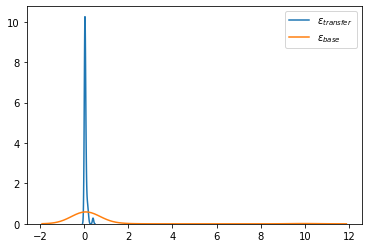

In [50]:
s = np.array(np.loadtxt('50_runs_stiff_transfer.txt'))
t = np.array(np.loadtxt('50_runs_stiff.txt'))

print(np.mean(s))
print(np.std(s))

sns.distplot(s, hist=False,
                 kde_kws={"shade": False},
                 norm_hist=False, label=r'$\varepsilon_{transfer}$')

print(np.mean(t))
print(np.std(t))

sns.distplot(t, hist=False,
                 kde_kws={"shade": False},
                 norm_hist=False, label=r'$\varepsilon_{base}$')

# plt.savefig('Transfer_histogram.png', dpi = 500, bbox_inches='tight')